In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 1. Load Dataset
df = pd.read_csv("Fraud.csv")
print("Before cleaning:", df.shape)
print(df.head())

Before cleaning: (6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
# 2. Drop useless ID/name columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [4]:
# 3. Encode 'type' column (convert to numeric dummies)
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [5]:
# 4. Check again (only numeric columns now)
print("After encoding:", df.shape)
print(df.dtypes)


After encoding: (6362620, 12)
step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [6]:
# 5. Define Features & Target
X = df.drop("isFraud", axis=1)
y = df["isFraud"]

In [7]:
# 6. Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 7. Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

### Logistic regression Classification report ###

In [9]:
print(" Logistic Regression Results:")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

 Logistic Regression Results:
[[1270828      76]
 [    834     786]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.91      0.49      0.63      1620

    accuracy                           1.00   1272524
   macro avg       0.96      0.74      0.82   1272524
weighted avg       1.00      1.00      1.00   1272524



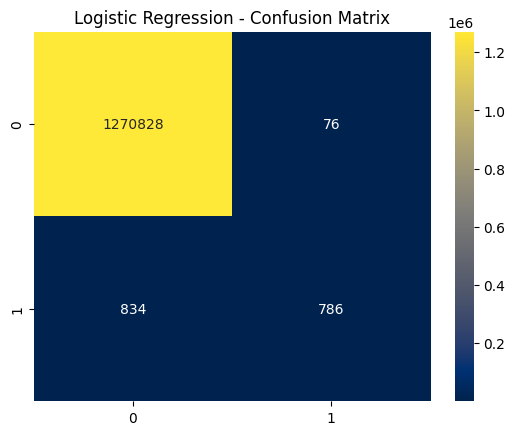

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='cividis')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()

In [11]:
# 8. Decision Tree
tree_model = DecisionTreeClassifier(max_depth=5)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

### Desicion tree classification report ### 

In [12]:
print("Decision Tree Results:")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Results:
[[1270654     250]
 [    897     723]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.74      0.45      0.56      1620

    accuracy                           1.00   1272524
   macro avg       0.87      0.72      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



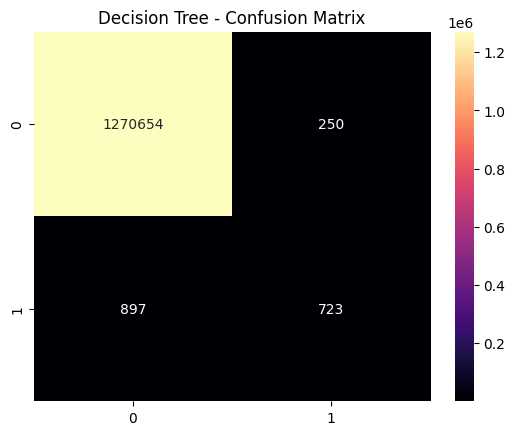

In [13]:
sns.heatmap(confusion_matrix(y_test, y_pred_tree), annot=True, fmt='d', cmap='magma')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

### Decision tree hyperparameter tuning ###

In [14]:
from scipy.stats import randint

In [15]:
param_dist_tree = {
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 20),
    'criterion': ['gini', 'entropy']
}


In [16]:
rand_tree = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=param_dist_tree,
    n_iter=20,          # Number of random combinations to try
    cv=3,               # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=2,           # Limit cores to avoid system resource error
    random_state=42
)

In [17]:
rand_tree.fit(X_train, y_train)
print("Best Decision Tree Parameters:", rand_tree.best_params_)

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 2}


In [18]:
best_tree = rand_tree.best_estimator_
y_pred_tree = best_tree.predict(X_test)

In [19]:
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

[[1270822      82]
 [    286    1334]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.82      0.88      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.91      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

